In [1]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u

In [2]:
#All Relevant nanapeaks functions

def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)

In [20]:
#Erin's code
# Design matrix
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1

omega = 2 * np.pi * nu

def easy_design_matrix(ts, om):
    return np.vstack([
        np.ones_like(ts),
        np.cos(om * ts),
        np.sin(om * ts)
    ]).T

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

A_easy = easy_design_matrix(t_fit, omega)

A_integral = integral_design_matrix(t_fit, omega, lc_exptime)

weight_fit = 1 / sigma_fit**2

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return A @ np.linalg.solve(ATA, ATb)

y_hat = weighted_least_squares(A_integral, flux_fit, weight_fit)
     



In [21]:
search_result = lk.search_lightcurve('KIC 7917485', mission='Kepler')
lc_collection = search_result.download_all()

In [22]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) ###frequency resolution in data
sampling_rate= np.median(np.diff(lc.time.value))
print(total_observation_time,sampling_rate)

1470.4623264496477 0.02043365134159103


In [23]:

f_max = (0.5 / (sampling_rate))

f_min = delta_f/3

frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

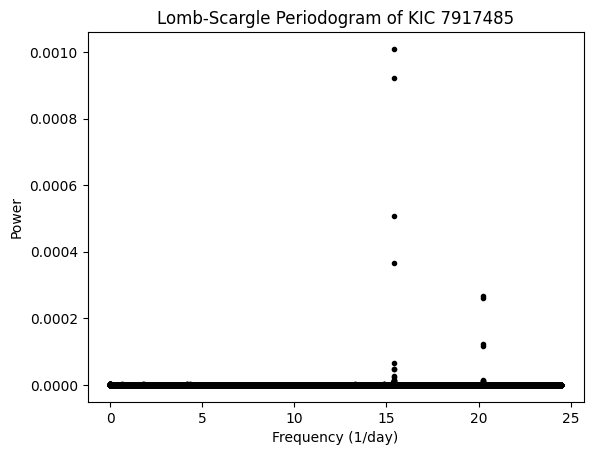

In [24]:
pg = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 7917485")
plt.show() 

In [25]:

num_of_mins = 20
indices = get_started(num_of_mins,freq,power)
refined_freq, refined_power, second_derivative = refine_peaks(freq,power, indices)
nu = refined_freq[0] #looking at highest power
print(nu)

15.382996803459365


In [26]:
#Erin's code/chi-squared stuff
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value


t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean) #good

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [27]:
#rando functions i use
def sharpness(second_derivative, y_new, index):
    sharpness = (-second_derivative[index]/y_new[index])**(1/2)
    return sharpness

def median(indices, xs, ys):
    good_medians = []
    for i in indices:
        leftside = ys[i-10:i]  
        rightside = ys[i+1:i+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        good_medians.append(median)
    return np.array(good_medians)

def find_min_and_refine(xs,ys):
    indxs, properties = find_peaks(-ys)
    min_index =  indxs[np.argsort(-ys[indxs])[:1]]
    refined_x, refined_y, second_derivative = refine_peaks(xs, ys, min_index)
    return refined_x, refined_y

def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  # Adjusted range around nu
chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])

In [29]:
#min finding?


nu_vals = []
best_freqs = []
best_chi2s = []

for peak in refined_freq:
    nu = peak
    fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  
    chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])
    best_freq, best_chi2 = find_min_and_refine(fine_freqs,chi2_fine)
    nu_vals.append(nu)
    best_freqs.append(best_freq.item())
    best_chi2s.append(best_chi2.item())

nu_vals = np.array(nu_vals)
best_freqs = np.array(best_freqs)
best_chi2s = np.array(best_chi2s)

In [30]:
I = np.argsort(best_chi2s)
for f1, f2, chi2 in zip(nu_vals[I], best_freqs[I], best_chi2s[I]):
    print(f1, f2, chi2, chi2-np.min(best_chi2s))

15.382996803459365 15.382021424062845 50287256.0 0.0
20.26289502133935 20.261915884105097 51628221.0 1340965.0
15.382006204921979 15.381322160947944 51628505.5 1341249.5
15.38401359329484 15.384687477298977 51651212.0 1363956.0
15.384707329530379 15.385390474974065 51757177.75 1469921.75
15.381321489566963 15.38061727917392 51759938.25 1472682.25
15.380643884976127 15.379982274614889 51863249.0 1575993.0
15.38538210145983 15.386022580577203 51873791.75 1586535.75
20.26189255460858 20.26121767370688 51997630.25 1710374.25
20.263903493172187 20.264579827123654 52006731.25 1719475.25
20.261208484085024 20.260502480605755 52026116.375 1738860.375
0.019412063791482005 0.019407141359175595 52029159.06791267 1741903.067912668
20.264590761088048 20.265290797466285 52032254.125 1744998.125
15.386058191166992 15.386748124015284 52043935.0 1756679.0
15.379965024487873 15.379256258501501 52045303.125 1758047.125
15.387422938432739 15.388066202140806 52106910.84375 1819654.84375
15.377257660066675 

In [31]:
def fit_and_subtract(om, ts, fs, ws, T):
    X = integral_design_matrix(ts, om, T)
    return fs - X @ np.linalg.solve(X.T @ (ws[:, None] * X), X.T @ (ws * fs))
    

In [32]:
flux_foo = fit_and_subtract(2. * np.pi * nu_vals[I][0], t_fit, flux_fit, weight_fit, lc_exptime)

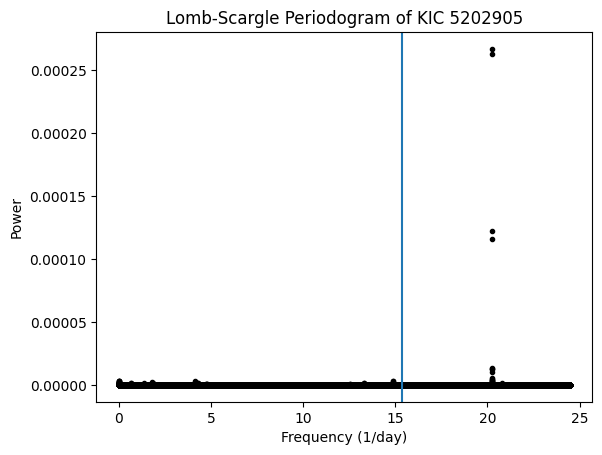

In [33]:
lc_foo = lc.copy()
lc_foo.flux = flux_foo

pg2 = lc_foo.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power2 = pg2.power.value
freq2 = pg2.frequency.to(1/u.day).value 

plt.plot(freq2, power2,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(nu_vals[I][0])
plt.show() 

In [34]:
print(nu_vals[I][0])

15.382996803459365
